## Install (Colab only)
Skip this step when running locally.

In [1]:
#!pip install neuromancer

*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy

import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
torch.manual_seed(0)

# Learning to Control an Energy Storage System in NeuroMANCER

This tutorial demonstrates the use of [Differentiable predictive control (DPC)](https://www.sciencedirect.com/science/article/pii/S0959152422000981) method to learn constrained neural policy for controlling [pumped-storage hydroelectricity](https://en.wikipedia.org/wiki/Pumped-storage_hydroelectricity) system described by [nonlinear ordinary differential equations (ODE)](https://en.wikipedia.org/wiki/Ordinary_differential_equation).


## Pumped-storage Hyrdoelectricity System

Lets consider a [pumped-storage hydroelectricity](https://en.wikipedia.org/wiki/Pumped-storage_hydroelectricity) (PSH) system which is a type of hydroelectric energy storage used by electric power systems for load balancing. 
[Load balancing](https://en.wikipedia.org/wiki/Load_balancing_(electrical_power)) or daily peak demand reserve refers to the use of various techniques by electrical power stations to store excess electrical power during low demand periods for release as demand rises. These techniques are an important part of modern power system that help to balance the time-varying load with the generation.
As of 2020, the largest form of [grid energy storage]((https://en.wikipedia.org/wiki/Grid_energy_storage)) is dammed hydroelectricity, with both conventional hydroelectric generation as well as pumped-storage hydroelectricity.

<img src="./figs/PSH.PNG" width="600">  

image adopted from: https://www.upsbatterycenter.com/blog/pumped-storage-hydroelectricity/


**System schematics**:  
<img src="../figs/two_tank_level.png" width="250">  

**System model**:  
A simplified system dynamics of PSH system is defined by following nonlinear ordinary differential equations (ODEs):
$$
 \frac{dx_1}{dt} = c_1 (1.0 - v)  p - c_2  \sqrt{x_1}
 $$
 
 $$
 \frac{dx_2}{dt}  = c_1 v p + c_2  \sqrt{x_1} - c_2 \sqrt{x_2}
$$  
With system states $x_1$, and $x_2$ representing liquid levels in tank 1 and 2, respectively. Control actions are pump modulation $p$, and valve opening $v$. The ODE system is parametrized by inlet and outlet valve coefficients $c_1$ and $c_2$, respectively.

System model and image adopted from: https://apmonitor.com/do/index.php/Main/LevelControlex.php/Main/LevelControl


Main/LevelControl

In [13]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1

## SINDy System Identification

First, we will construct the SINDy system identification problem to learn our ODE. For a more in depth example of using SINDy for system identification in Neuromancer, go [here](https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/ODEs/Part_9_SINDy.ipynb).

In [4]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainU = train_sim['U'][:length].reshape(nbatch, nsteps, nu)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'r': trainX, 'xn': trainX[:, 0:1, :], 'u': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devU = dev_sim['U'][:length].reshape(nbatch, nsteps, nu)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'r': devX, 'xn': devX[:, 0:1, :], 'u': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testU = test_sim['U'][:length].reshape(1, nsim, nu)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'r': testX, 'xn': testX[:, 0:1, :], 'u': testU}

    return train_loader, dev_loader, test_data

In [5]:
nsim = 1000   # number of simulation steps in the dataset
nsteps = 10   # number of prediction horizon steps in the loss function
bs = 50     # minibatching batch size
train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)

## Construct SINDy Model

Here we construct a SINDy model $\dot{x_k} = \theta(x_k, u_k)\xi_k$, which uses aims to fit the correct coefficient values $\xi_k$ to properly predict the change in $x_k$ given the state and the input. In the construction of our model, we add bounds on the states, which is based on prior knowledge we have about the two tank system.

In [6]:
theta_1 = library.PolynomialLibrary(nx, nu, 2)

theta_2_funs = [lambda X, u: torch.sqrt(X[:,0]), lambda X, u: torch.sqrt(X[:,1])]
theta_2_names = ["sqrt(x_0)", "sqrt(x_1)"]
theta_2 = library.FunctionLibrary(theta_2_funs, nx, nu, theta_2_names)


fx = sindy.SINDy(library.CombinedLibrary([theta_1, theta_2]))

In [7]:
integrator = integrators.Euler(fx, h=ts)
integrator_node = Node(integrator, ['xn', 'u'], ['x'])
x_bound = Node(lambda x: torch.clamp(x, xmin, xmax), ['x'], ['xn'])
dynamics_model = System([integrator_node, x_bound], nsteps=nsteps, name="dynamics_model")

## Define system identification loss function terms


In [8]:
# %% Constraints + losses:
x = variable("r")
xhat = variable('xn')[:, :-1, :]

# one step loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reference tracking loss
reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

#sparsity
l1 = variable([x], lambda x: torch.norm(list(fx.parameters())[0]))
loss_l1 = 0.000001*(l1 == 0)

## Construct System ID learning problem

In [9]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss, loss_l1]

# create constrained optimization loss
loss = PenaltyLoss(objectives, [])
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

In [10]:
optimizer = torch.optim.AdamW(problem.parameters(),
                             lr=0.01)
# trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=200,
    epochs=1000,
    epoch_verbose=200,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)

In [11]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0  train_loss: 1.407421350479126
epoch: 200  train_loss: 0.002438385272398591
epoch: 400  train_loss: 0.0003757216618396342
epoch: 600  train_loss: 0.00014694672427140176
epoch: 800  train_loss: 5.161362423677929e-05


<All keys matched successfully>

## Model Evaluation

Here we print out our model to find the active terms. Additionally, we plot our model against the test data, so that we can see that the model can accurately predict the trajectory of our state variables. 

In [12]:
print(fx)

dx0/dt = -0.072*x0 + 0.099*x1 + 0.031*u0 + 0.140*x0^2 + -0.193*x0*x1 + -0.022*x0*u0 + -0.074*x0*u1 + -0.098*x1^2 + 0.194*x1*u0 + -0.114*x1*u1 + 0.060*u0^2 + -0.027*u1^2 + -0.033*sqrt(x_1) 
dx1/dt = -0.259*x0 + 0.180*x1 + -0.010*u0 + 0.215*x0^2 + 0.065*x0*x1 + -0.111*x0*u0 + -0.068*x0*u1 + -0.213*x1^2 + 0.120*x1*u0 + 0.046*x1*u1 + 0.039*u0^2 + 0.020*u0*u1 + 0.013*u1^2 + 0.184*sqrt(x_0) + -0.148*sqrt(x_1) 



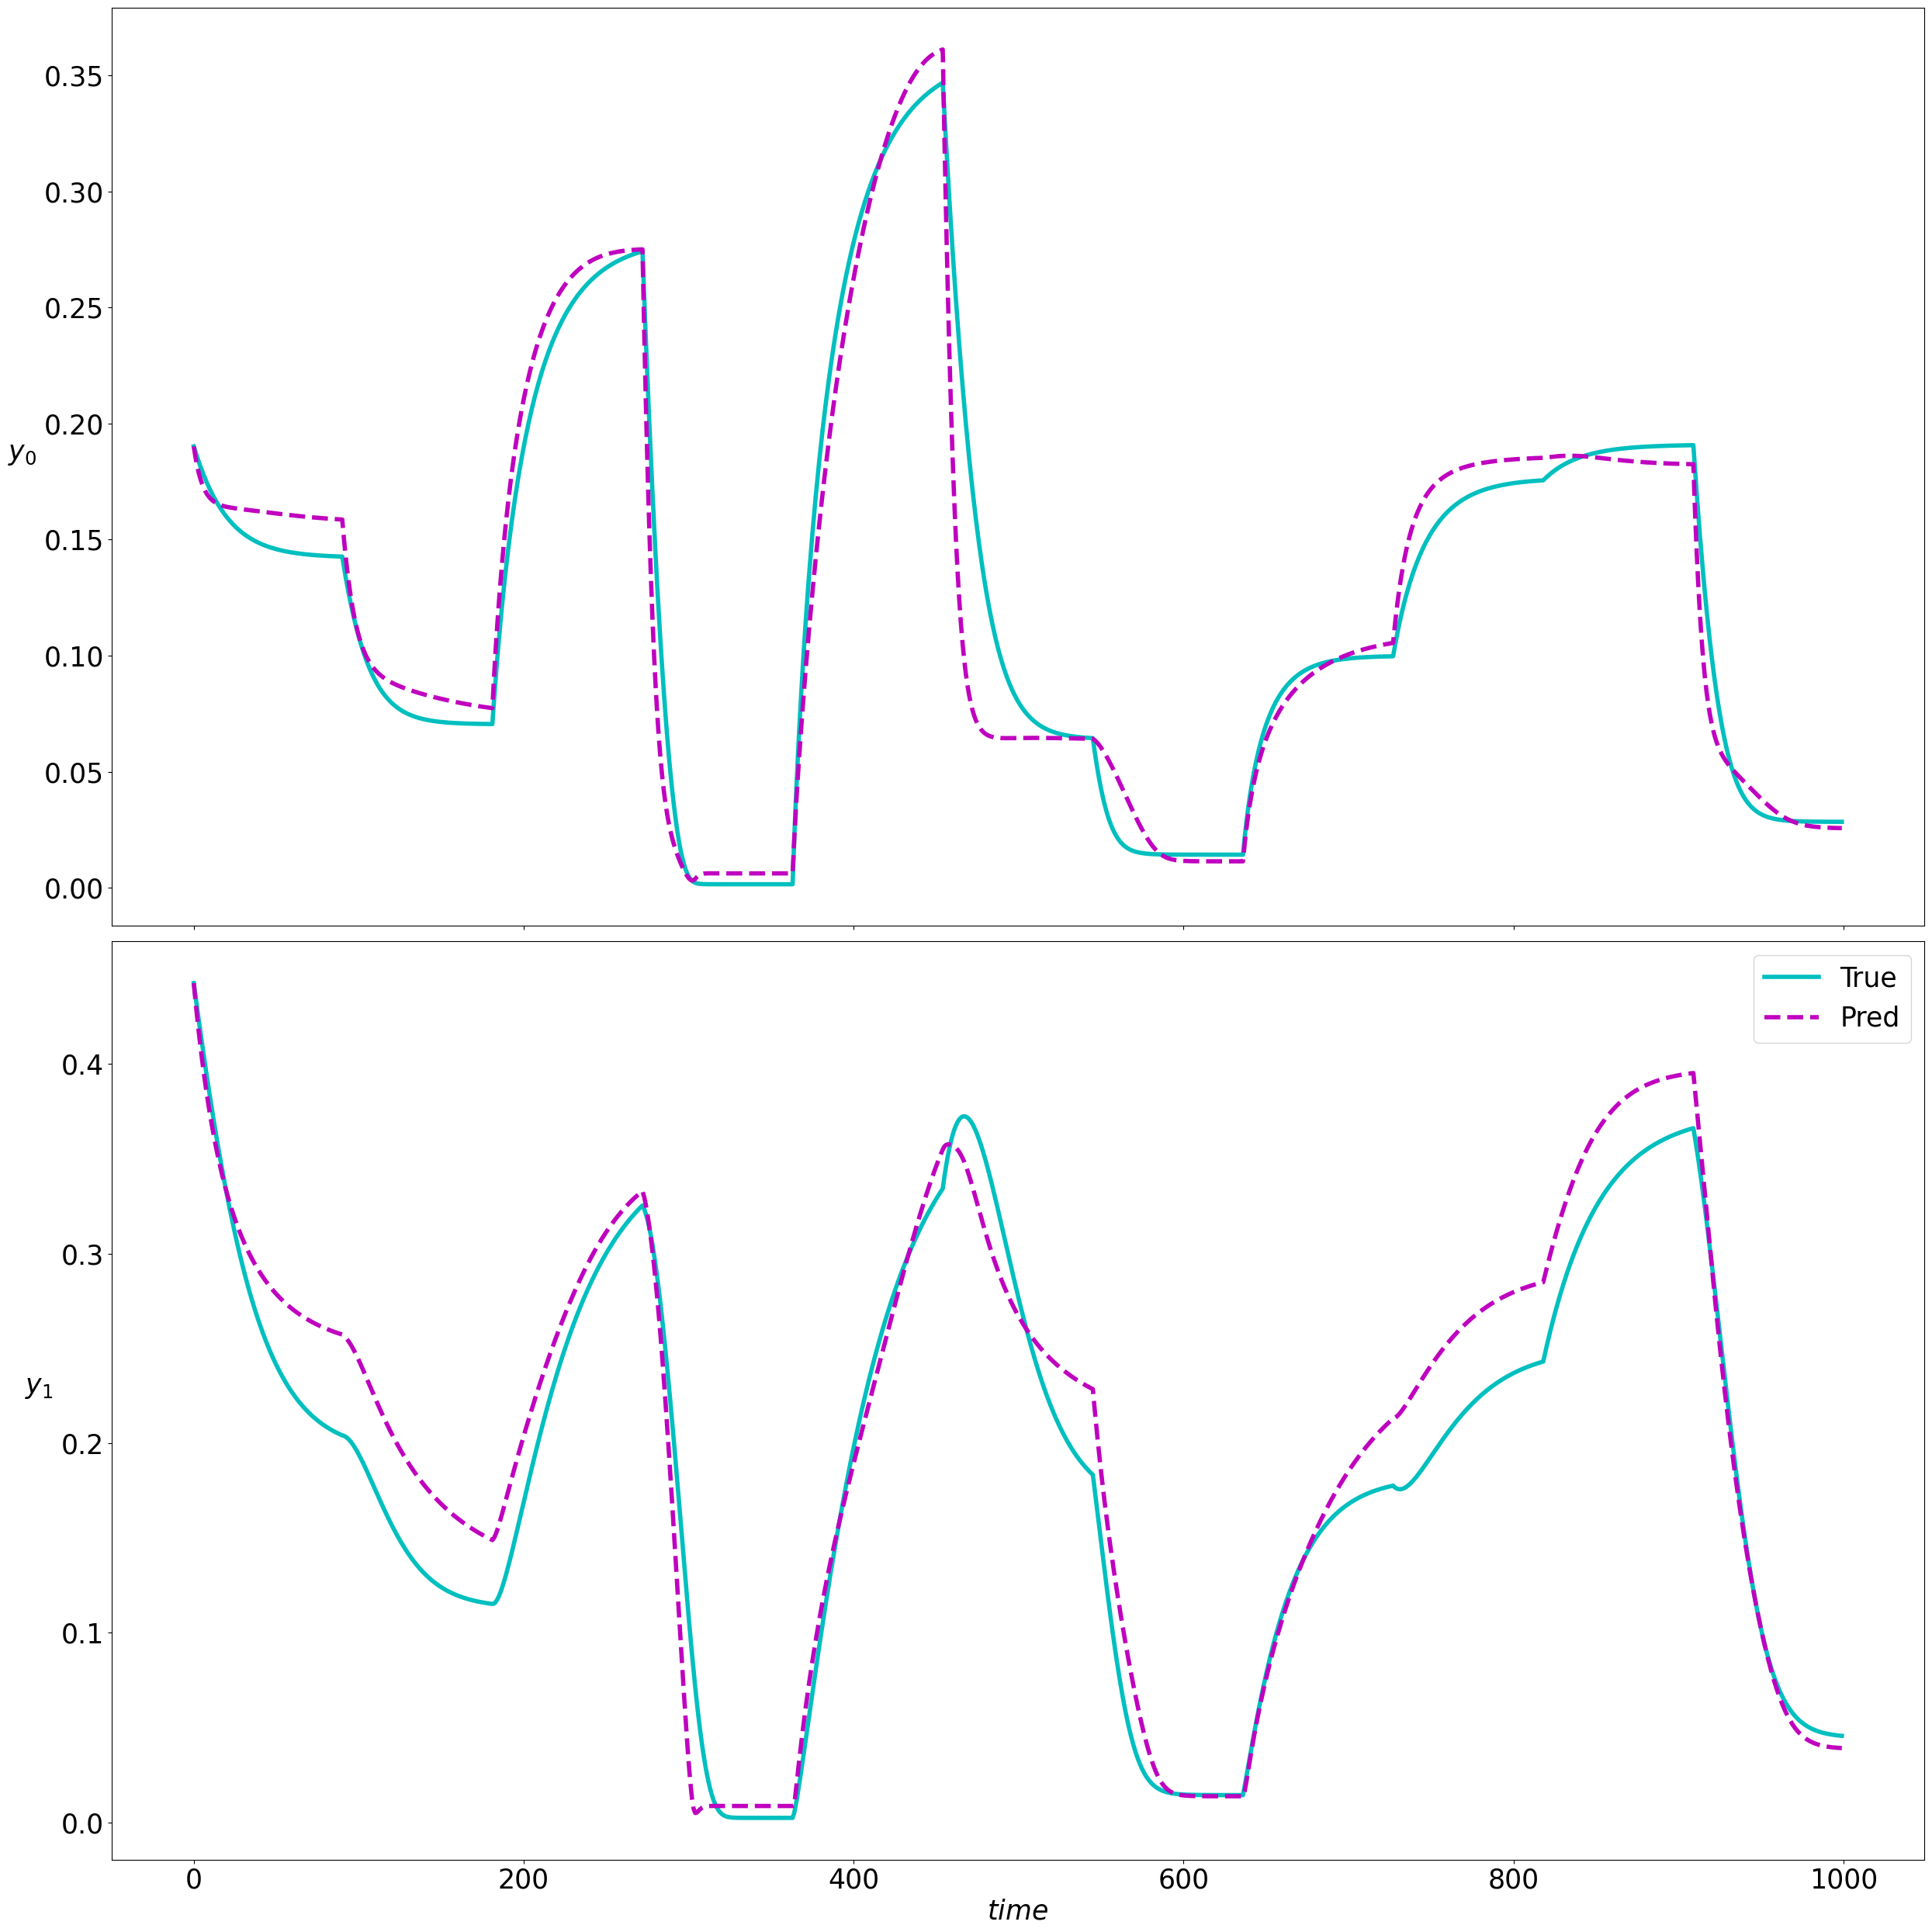

In [13]:
dynamics_model.nsteps = test_data['r'].shape[1]
test_output = dynamics_model(test_data)

pred_traj = test_output['xn'][:, :-1, :]
true_traj = test_data['r']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

# Differentiable Predictive Control 

Next we show how to solve the corresponding parametric optimal control using the [DPC method](https://www.sciencedirect.com/science/article/pii/S0959152422000981) implemented in Neuromancer.

**Schematics of the Differentiable Predictive Control method**:  
<img src="./figs/DPC_simple_method.png" width="600">  

**Neural control policy**:  
The objective of this tutorial is to learn neural control policy $u_k = \pi(x_k, R)$ to control the tank levels by modulating the pump and valve control actions $u_k = [p_k, v_k]$. The policy takes in the measurements of system states $x_k$ at thime $k$, prediciton of desired references $R = [r_k, ..., r_{k+N}]$ over pre-defined horizon $N$.

**Differentiable system model**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In this example, we compactly represent the system model by ODE equations  $\text{ODESolve}(\theta(x^i_k, u^i_k)\xi_k)$  describing the governing dynamics of the controlled system. 

**Differentiable predictive control problem formulation**:  
We learn the explicit neural control policy by solving the following parametric optimal control problem: 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m  \Big( \sum_{k=1}^{N-1} Q_x||x^i_k - r^i_k||_2^2  + Q_N||x^i_N - r^i_N||_2^2 \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(\theta(x^i_k, u^i_k)\xi_k) \\
&                     && u^i_k = \pi_{\theta}(x^i_k, R^i) \\
&                     && 0 \le x^i_k \le 1 \\
&                     && 0 \le u^i_k \le 1 \\
&                     && x^i_0 \sim \mathcal{P}_{x_0} \\
&                     && R^i \sim  \mathcal{P}_R
\end{align}
$$  
The objective function is to minimize the reference tracking error $||x^i_k - r^i_k||_2^2$ over pre-defined prediction horizon $N$ weighted by a scalar $Q_x$, including terminal penalty weighted by $Q_N$.  The parametric neural control policy is given by $\pi_{\theta}(x^i_k, R^i)$. The neural control policy is optimized over a problem parameters sampled from the distributions $\mathcal{P}_{x_0}$, and $\mathcal{P}_R$, for state initial conditions, and references, respectively. The parameters $\theta$ are optimized with stochastic gradient descent.

## Training dataset generation

For a training dataset we randomly sample initial conditions of states and sequence of admissible reference trajectories over predefined prediction horizon from given distributions $\mathcal{P}_{x_0}$, and $\mathcal{P}_R$, respectively.

In [26]:
def get_policy_data(nsteps, n_samples):
    #  sampled references for training the policy
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Training dataset
    train_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                              'r': batched_ref}, name='train')
    
    # sampled references for development set
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Development dataset
    dev_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                            'r': batched_ref}, name='dev')
    
    # torch dataloaders
    batch_size = 200
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               collate_fn=train_data.collate_fn,
                                               shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                             collate_fn=dev_data.collate_fn,
                                             shuffle=False)
    return train_loader, dev_loader

nsteps = 50  # prediction horizon
n_samples = 3000    # number of sampled scenarios

train_loader, dev_loader = get_policy_data(nsteps, n_samples)

## System model and Control policy in Neuromancer

Here we construct a closed-loop system as differentiable computational graph by coinnecting the system dynamics model  $x_{k+1} = \text{ODESolve}(\theta(x_k, u_k)\xi_k)$ with neural control policy $u_k = \pi_{\theta}(x_k, R)$. Hence we obtain a trainable system architecture: 
$x_{k+1} = \text{ODESolve}(\theta(x_k, \pi_{\theta}(x_k, R))\xi_k)$. In this example our system dynamics model is our learned SINDy model.

In [21]:
# symbolic system model
model = Node(integrator, ['xn', 'u'], ['x'], name='model')

# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['xn', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, model, x_bound], nsteps=nsteps)
# cl_system.show()

## Differentiable Predictive Control objectives and constraints

Here we take advantage of Neuromancer's high level symbolic language to define objective and constraint terms of our optimal control problem.

In [18]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]

## Differentiable optimal control problem 

Here we put things together to construct a differentibale optimal control problem.

In [17]:
# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
# problem.show()

## Solve the problem

We solve the problem using stochastic gradient descent over pre-defined training data of sampled parameters.

In [18]:
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.002)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=100,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 3.5614821910858154
epoch: 1  train_loss: 3.110586643218994
epoch: 2  train_loss: 2.681307554244995
epoch: 3  train_loss: 2.1627707481384277
epoch: 4  train_loss: 1.5933849811553955
epoch: 5  train_loss: 1.128987431526184
epoch: 6  train_loss: 0.8663768768310547
epoch: 7  train_loss: 0.7341722249984741
epoch: 8  train_loss: 0.6698929667472839
epoch: 9  train_loss: 0.6300025582313538
epoch: 10  train_loss: 0.5991824269294739
epoch: 11  train_loss: 0.5670934319496155
epoch: 12  train_loss: 0.5426653027534485
epoch: 13  train_loss: 0.52264803647995
epoch: 14  train_loss: 0.5105507373809814
epoch: 15  train_loss: 0.49784475564956665
epoch: 16  train_loss: 0.48338207602500916
epoch: 17  train_loss: 0.472815603017807
epoch: 18  train_loss: 0.46379977464675903
epoch: 19  train_loss: 0.4564729630947113
epoch: 20  train_loss: 0.4496457576751709
epoch: 21  train_loss: 0.44339197874069214
epoch: 22  train_loss: 0.4363335967063904
epoch: 23  train_loss: 0.4313509464263916
epoc

<All keys matched successfully>

# Evaluate best model on a system rollout 

Here we generate 5 different reference system states over 750 timesteps to see how our control policy will act to stabilize the system to these reference states.

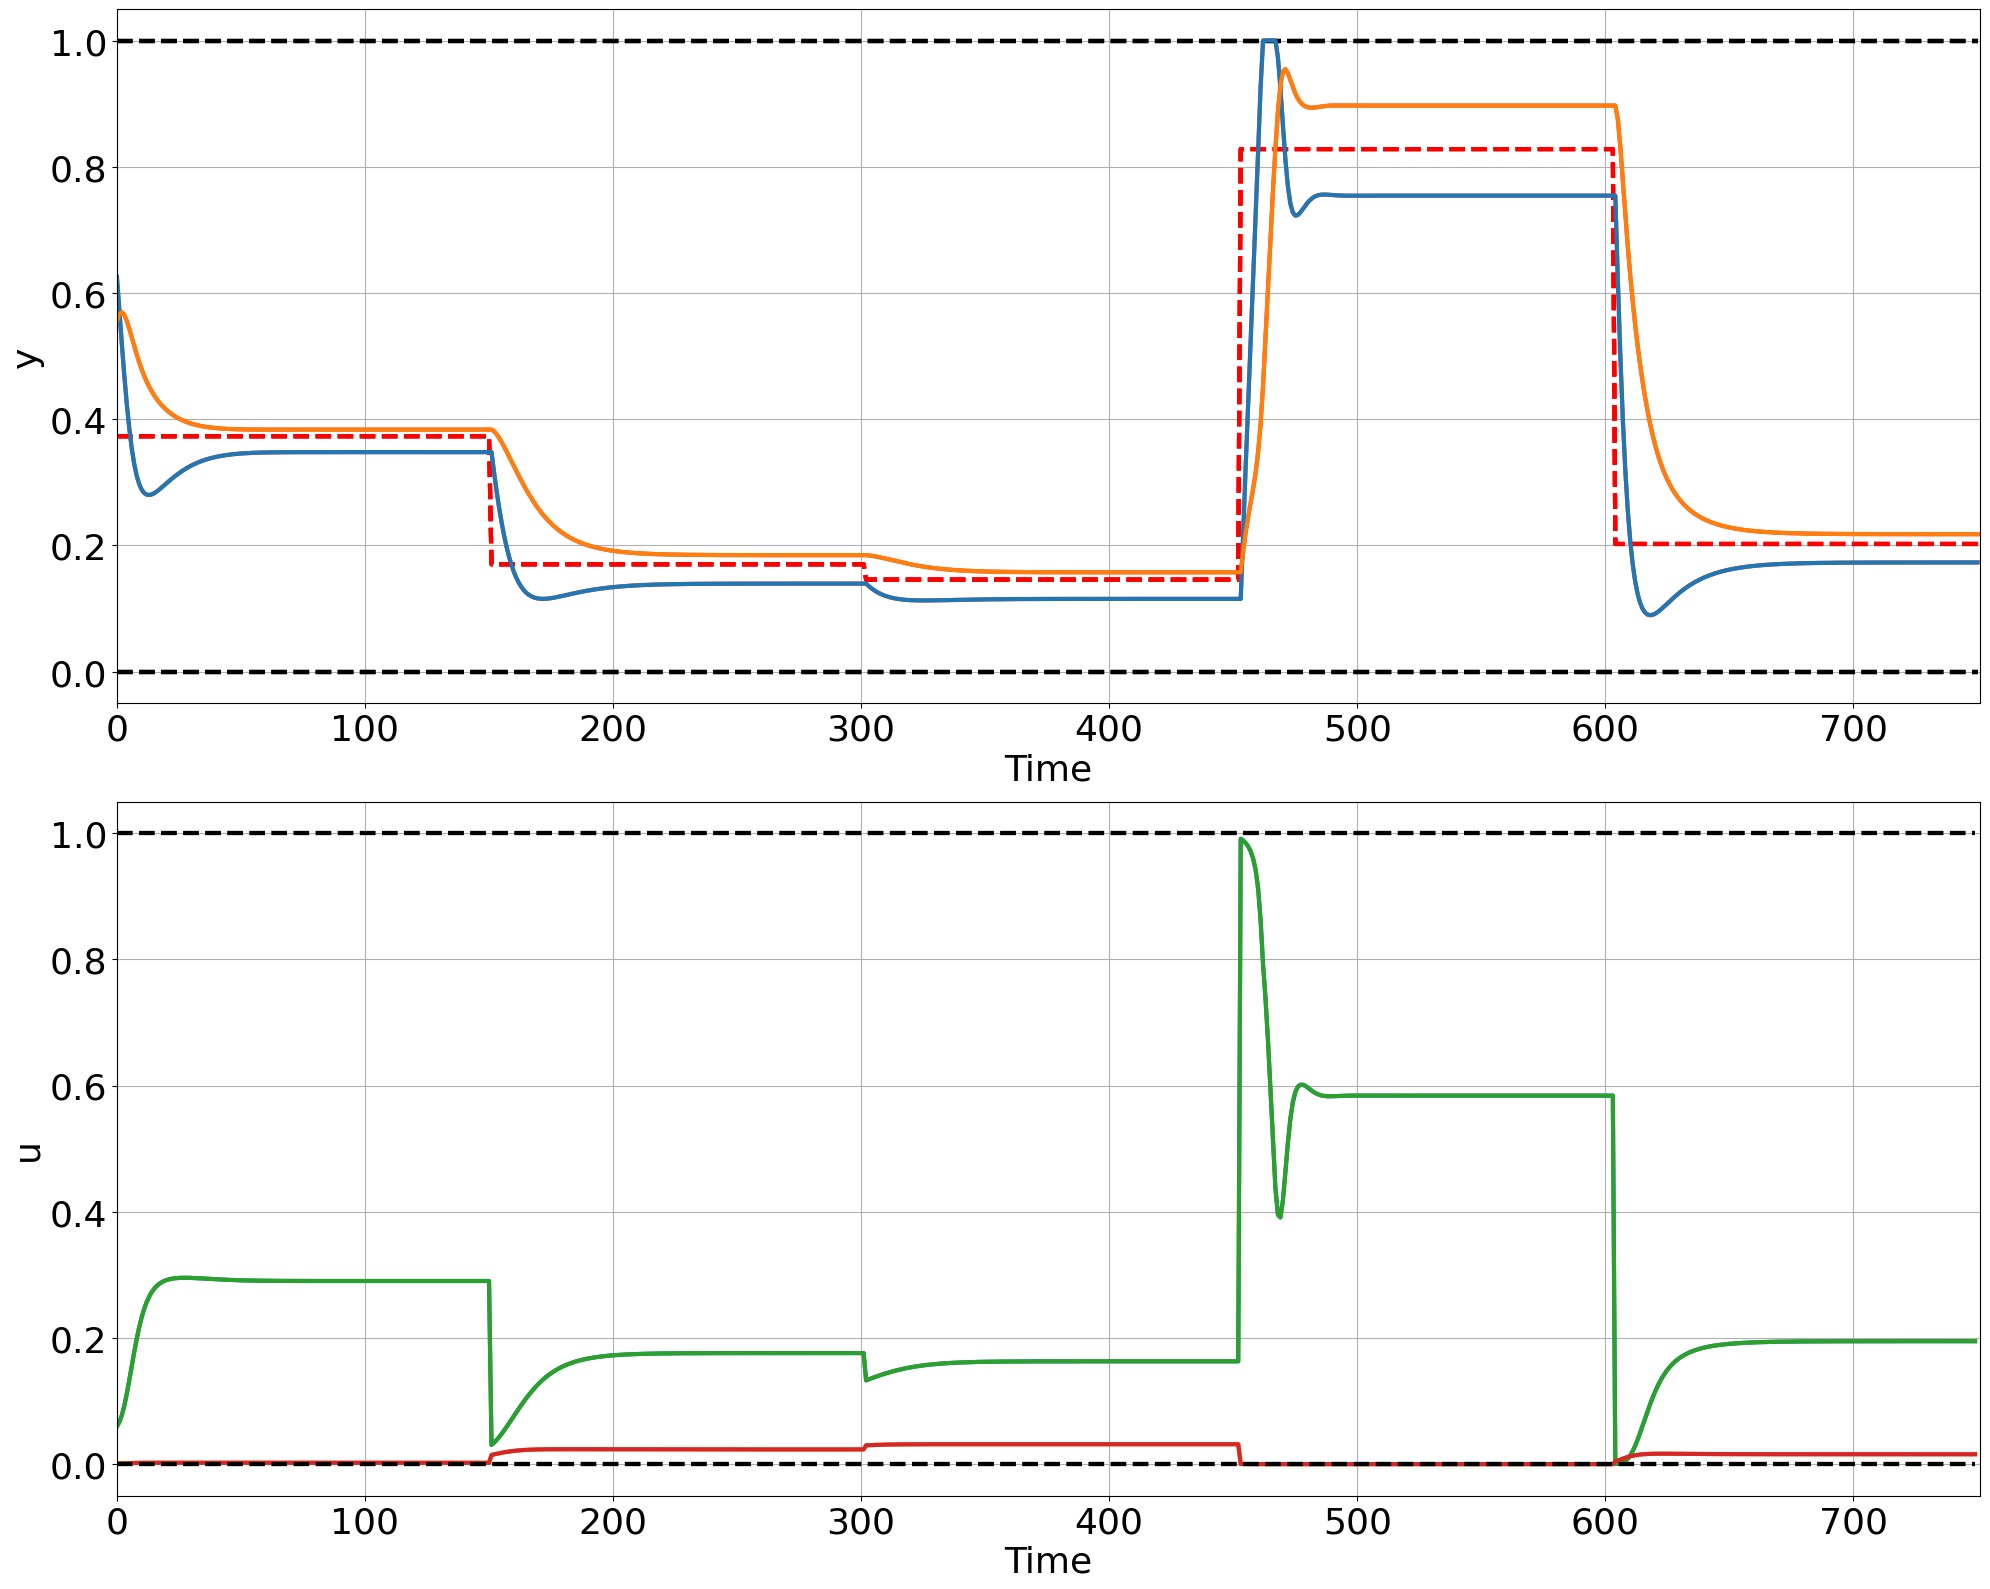

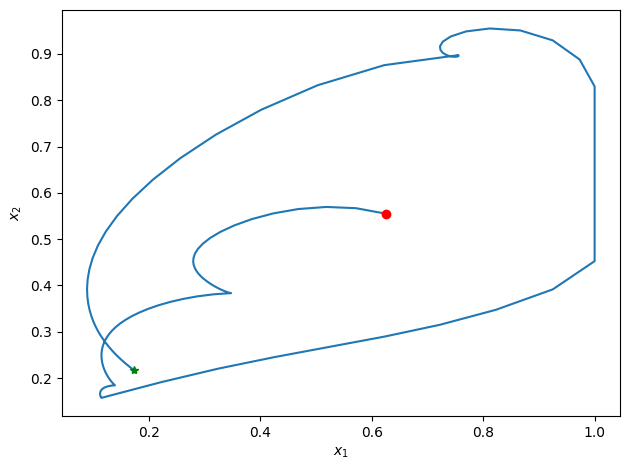

In [19]:
nsteps = 750
step_length = 150
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=5)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)
# plot phase portrait
pltPhase(X=trajectories['xn'].detach().reshape(nsteps + 1, nx))

## Dictionary Policy

Additionally, we can learn a sparse dictionary policy using the SINDy object. So now our neural control policy $u_k = \pi_{\theta}(x_k, R)$ can be represented by a sparse dictionary regression model instead of a neural network. As such we have $u_k = \theta(x_k, R)\xi_k$, where $\theta$ is our library and $\xi_k$ is our learned coefficient. Remember, we have the constraint for control inputs: $0 \le u^i_k \le 1$. So, to add this constraint, we use the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) to ensure that all control inputs generated by our policy meet this constraint.

In [14]:
from neuromancer.dynamics.ode import TwoTankParam

sys = TwoTankParam()
integrator = integrators.RK4(sys, h=ts)

In [28]:
torch.manual_seed(0)
nsteps_init = 10
n_iter = 1
max_freq = 5
max_degree = 2
nsteps = nsteps_init  # prediction horizon
n_samples = 2000    # number of sampled scenarios

theta_1 = library.FourierLibrary(nx, nref, max_freq=max_freq)
theta_2 = library.PolynomialLibrary(nx, nref, max_degree=max_degree)
policy_sindy = sindy.SINDy(library.CombinedLibrary([theta_1, theta_2]))
policy_node = Node(policy_sindy,  ['xn', 'r'], ['u_unbound'])
integrator_node = Node(integrator, ['xn', 'u'], ['xn'])
u_bound = Node(lambda u: torch.sigmoid(u) * (umax-umin) + umin, ['u_unbound'], ['u'])

sindy_system = System([policy_node, u_bound, integrator_node], nsteps=nsteps)

In [22]:
# variables
x = variable('xn')
ref = variable('r')
u = variable('u')

# objectives
regulation_loss = 15.*((x == ref)^2)  # target posistion

# list of constraints and objectives
objectives = [regulation_loss]
constraints = [terminal_lower_bound_penalty, terminal_upper_bound_penalty]

In [23]:
# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [sindy_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
# problem.show()

In [24]:
optimizer = torch.optim.AdamW(policy_node.parameters(), lr=0.01)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=250,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=200,
)

## Model Training

Here, we draw on the idea of [cirriculum learning](https://en.wikipedia.org/wiki/Curriculum_learning) to gradually increase the number of rollout steps of our model. So, we start with by learning the sparse dictionary policy for how to control the system for the next two timesteps. As we progress through training, we increase the number of timesteps we learn for which we learn the policy. This progressive type of training allows us to learn the policy while gradually making the learning task more complex.

In [29]:
for _ in range(n_iter):
    train_loader, dev_loader = get_policy_data(nsteps, n_samples)
    trainer.train_data, trainer.dev_data = train_loader, dev_loader 
    trainer.problem = problem
    
    # Train control policy
    best_model = trainer.train()
    
    # load best trained model
    trainer.model.load_state_dict(best_model)

    nsteps *= 2
    sindy_system.nsteps = nsteps
    trainer.badcount = 0

RuntimeError: The size of tensor a (5) must match the size of tensor b (11) at non-singleton dimension 1

## Compare Dictionary Policy to Neural Policy
Again, we rollout both of our models to 5 desired reference states over 750 timestep to compare the two policies. As we can see, our dictionary policy does a slightly better job of controlling our system than the neural policy.

In [ ]:
nsteps = 750
step_length = 150

# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=5)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)

# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}
cl_system.nsteps = nsteps
sindy_system.nsteps = nsteps
print(data['r'].shape)
# perform closed-loop simulation
trajectories_nn = cl_system(data)
trajectories_sindy = sindy_system(data)

In [ ]:
nn_loss = torch.nn.functional.mse_loss(trajectories_nn['xn'], data['r'])
sindy_loss = torch.nn.functional.mse_loss(trajectories_sindy['xn'], data['r'])

In [ ]:
fig, ax = plt.subplots(nrows=2, constrained_layout=True)
ax[0].set_title("State Trajectories")
ax[0].plot(data['r'].detach().numpy().reshape(nsteps+1, nref), '-', color="black", label="reference")
ax[0].plot(trajectories_nn['xn'].detach().numpy().reshape(nsteps+1, nx), label='nn policy')
ax[0].plot(trajectories_sindy['xn'].detach().numpy().reshape(nsteps+1, nx), '--', label='sindy policy')
ax[1].set_title("Control Inputs")
ax[1].plot(trajectories_nn['u'].detach().numpy().reshape(nsteps, nu), label='nn policy')
ax[1].plot(trajectories_sindy['u'].detach().numpy().reshape(nsteps, nu), '--', label='sindy policy')
ax[1].text(0, -1, f"MSE using NN Policy: {nn_loss.item():.4f}\nMSE using SINDy Policy: {sindy_loss.item():.4f}")
plt.legend()
plt.savefig('two_tank.png', bbox_inches='tight')

In [ ]:
from ray import train, tune

In [ ]:
###def train_func(optim, system):
    nsteps = system.nsteps
    # variables
    x = variable('xn')
    ref = variable('r')
    u = variable('u')

    # objectives
    regulation_loss = 15.*((x == ref)^2)  # target posistion

    # list of constraints and objectives
    objectives = [regulation_loss]
    constraints = [terminal_lower_bound_penalty, terminal_upper_bound_penalty]

    # data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
    components = [system]
    # create constrained optimization loss
    loss = PenaltyLoss(objectives, constraints)
    # construct constrained optimization problem
    problem = Problem(components, loss)
    # plot computational graph
    # problem.show()
     #  Neuromancer trainer
    trainer = Trainer(
        problem,
        None,
        None,
        optimizer=optim,
        epochs=250,
        train_metric='train_loss',
        eval_metric='dev_loss',
        warmup=200,
    )
    for _ in range(n_iter):
        train_loader, dev_loader = get_policy_data(nsteps, n_samples)
        trainer.train_data, trainer.dev_data = train_loader, dev_loader 
        trainer.problem = problem
    
        # Train control policy
        best_model = trainer.train()
    
        # load best trained model
        trainer.model.load_state_dict(best_model)

        nsteps *= 2
        system.nsteps = nsteps
        trainer.badcount = 0

def test(system, test_data):
    nsteps = 750
    step_length = 150
    system.nsteps = nsteps

    # perform closed-loop simulation
    trajectories_sindy = system(test_data)

    return torch.nn.functional.mse_loss(trajectories_sindy['xn'], data['r']).item()

In [ ]:
def objective(config):
    torch.manual_seed(0)
    nsteps_init = config["n_steps"]
    n_iter = config["n_iter"]
    max_freq = config["max_freq"]

    nsteps = nsteps_init  # prediction horizon
    n_samples = 2000    # number of sampled scenarios

    theta_1 = library.FourierLibrary(nx, nref, max_freq=max_freq)

    policy_sindy = sindy.SINDy(library.CombinedLibrary([theta_1]))
    policy_node = Node(policy_sindy,  ['xn', 'r'], ['u_unbound'])
    u_bound = Node(config['bound_fun'], ['u_unbound'], ['u'])

    sindy_system = System([policy_node, u_bound, integrator_node, x_bound], nsteps=nsteps)

    optimizer = torch.optim.AdamW(policy_node.parameters(), lr=0.01)
   
    train_func(optimizer, sindy_system)
    acc = test(sindy_system, data)  # Compute test accuracy
    print(f"Loss: {acc}")
    tune.report({"eval_loss": acc})  # Report to Tune

def sigmoid_bound(u):
    return torch.sigmoid(u) * (umax-umin) + umin

def clamp_bound(u):
    return torch.clamp(u, umin, umax)

search_space = {"n_steps": tune.grid_search([2]), "n_iter": tune.grid_search([1]),
               "max_freq": tune.grid_search([1, 2, 3, 4, 5]), "bound_fun": tune.grid_search([sigmoid_bound, clamp_bound])}


tuner = tune.Tuner( 
    objective,
    tune_config=tune.TuneConfig(
        metric="_metric/eval_loss",
        mode="min",    
    ),
    param_space=search_space,
)
results = tuner.fit()
print("Best config is:", results.get_best_result().config)

In [ ]:
results.get_dataframe().to_csv("results.csv")